# Boosted Trees Regression (BQML)

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available
# on an “as is,” “as available,” and “with all faults” basis, solely for
# illustrative purposes, and without warranty or representation of any kind.
# This solution is experimental, unsupported and provided solely for your
# convenience. Your use of it is subject to your agreements with Google, as
# applicable, and may constitute a beta feature as defined under those
# agreements.  To the extent that you make any data available to Google in
# connection with your use of the solution, you represent and warrant that you
# have all necessary and appropriate rights, consents and permissions to permit
# Google to use and process that data.  By using any portion of this solution,
# you acknowledge, assume and accept all risks, known and unknown, associated
# with its usage, including with respect to your deployment of any portion of
# this solution in your systems, or usage in connection with your business,
# if at all.
###########################################################################

## 0) Dependencies

In [1]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'OnStar_RBA_0708' #add proj name and dataset

In [2]:
# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = project_name #update project name
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False


# data processing libraries
import numpy as np
import pandas as pd


# modeling and metrics
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

!pip install relativeImp
from relativeImp import relativeImp
!pip install shap
import shap

# visutalization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 29.5 MB/s eta 0:00:00


## 1) Import dataset

Import the data using the bigquery magics (%% command).
Pulls all of the data from the cleaned data table and stores into a dataframe "df"

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [ ]:
# %%bigquery df
# SELECT *
# FROM `.RBA_demo.cleaned_data`
# ORDER BY date; #update project name

In [5]:
#update file name
#file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data.csv'
file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data_0708.csv'
df_raw = pd.read_csv(file_name)
df_raw.fillna(0, inplace=True)


#df = df_raw.drop(columns = ['DIV_WYG_PPl21_0p0_0d0_12']).copy()
df = df_raw.copy()

df.head()

,Date,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_0,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_0,C_DIV_BUY_PREMIUMl21_0p0_0d0_06,C_DIV_BUY_SSl21_0p0_0d0_12,C_DIV_CONN_DATAl21_0p0_0d0_12,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_0,...,DIV_PLANPAGE_ESSl21_0p0_0d0_06,DIV_PLANPAGE_HOMEl21_0p0_0d0_06,OC_APP_Accessl21_0p0_0d0_06,OC_PAGE_PREFPLl21_0p0_0d0_12,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_12,Is_Holiday,Is_NYE
0,10/13/2023,729,-1.205102,-0.307094,-1.194541,-0.474351,-0.705212,-0.093944,-0.554724,0.785728,...,-0.380979,-0.773997,-0.693878,-1.450006,-0.612203,-1.013031,0.706098,-0.435712,0,0
1,10/14/2023,936,-1.108022,-1.827942,-0.955605,-0.772672,0.808002,-0.579551,-0.109231,0.111436,...,-0.395107,-0.783669,-0.566780,-1.284105,-0.663551,-1.013031,0.622132,0.506578,0,0
2,10/15/2023,787,-1.593424,-2.045206,-1.855596,-1.496538,-1.079448,-1.391312,0.510846,-1.068574,...,-0.467866,-1.784458,-0.687852,-1.478292,-1.195888,-1.013031,0.586147,-1.075122,0,0
3,10/16/2023,1030,-1.156562,-1.502046,-0.999979,-0.698092,-0.916737,-0.572303,-1.560092,-0.731428,...,-0.396858,-0.842286,0.757340,-0.777197,-0.168277,0.603343,0.686106,-1.277042,0,0
4,10/17/2023,950,-1.302183,-1.393414,-1.002255,-1.470215,-0.664534,-0.825978,-1.385507,-0.267853,...,0.157420,-0.450040,0.104867,-1.071958,-0.427817,-0.819067,0.098345,-1.277042,0,0


In [6]:
df.columns

Index(['Date', 'A_OC_GOOGLE_SHOPPING', 'C_DIV_BUY_CONNECTEDl21_0p0_0d0_0',
       'C_DIV_BUY_ESSENTIALSl21_0p0_0d0_0', 'C_DIV_BUY_PREMIUMl21_0p0_0d0_06',
       'C_DIV_BUY_SSl21_0p0_0d0_12', 'C_DIV_CONN_DATAl21_0p0_0d0_12',
       'C_DIV_CONN_REMOTEl21_0p0_0d0_12', 'C_DIV_CONN_TRYl21_0p0_0d0_06',
       'C_DIV_GETNOW_CONNl21_0p0_0d0_0', 'C_DIV_GETNOW_ESSl21_0p0_0d0_12',
       'C_DIV_GETNOW_PREMl21_0p0_0d0_06', 'C_DIV_GETNOW_SSl21_0p0_0d0_12',
       'C_PP_PKG_APP_ACCESSl21_0p0_0d0_12', 'C_PP_PKG_CONNECTEDl21_0p0_0d0_12',
       'C_PP_PKG_ESSl21_0p0_0d0_06', 'C_PP_PKG_PREMl21_0p0_0d0_0',
       'C_PP_PKG_REMOTEl21_0p0_0d0_0', 'C_PP_PKG_SCl21_0p0_0d0_06',
       'C_PP_PKG_SSl21_0p0_0d0_06', 'DIV_GMOC_SHOP_ESSl21_0p0_0d0_0',
       'DIV_GMOC_SHOP_REMOTEl21_0p0_0d0_0', 'DIV_GMOC_SHOP_SSl21_0p0_0d0_0',
       'DIV_PKG_CONN_SERVICESl21_0p0_0d0_0',
       'DIV_PKG_HDStreamingl21_0p0_0d0_12', 'DIV_PKG_SS_CRASHl21_0p0_0d0_12',
       'DIV_PLANPAGE_ESSl21_0p0_0d0_06', 'DIV_PLANPAGE_HOMEl21_0p0_

In [7]:
df.describe()

,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_0,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_0,C_DIV_BUY_PREMIUMl21_0p0_0d0_06,C_DIV_BUY_SSl21_0p0_0d0_12,C_DIV_CONN_DATAl21_0p0_0d0_12,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_0,C_DIV_GETNOW_ESSl21_0p0_0d0_12,...,DIV_PLANPAGE_ESSl21_0p0_0d0_06,DIV_PLANPAGE_HOMEl21_0p0_0d0_06,OC_APP_Accessl21_0p0_0d0_06,OC_PAGE_PREFPLl21_0p0_0d0_12,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_12,Is_Holiday,Is_NYE
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,...,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,1114.566038,0.023971,0.005479,0.043088,0.018490,0.047020,-0.025773,0.025115,0.000115,-0.019334,...,-0.005906,0.031590,0.069970,0.025019,0.021183,-0.043817,-0.085467,-0.058701,0.042453,0.009434
std,541.768458,1.009973,0.991937,1.018506,1.011862,1.020847,1.002644,1.003996,0.999183,0.997960,...,0.993740,0.988757,1.022555,1.005126,0.985134,0.990282,0.985055,0.977545,0.202097,0.096898
min,354.000000,-1.836124,-2.045206,-1.859009,-2.018598,-2.161478,-1.637739,-1.969464,-1.911439,-0.848306,...,-0.546814,-2.243528,-2.504750,-1.807850,-1.539545,-1.013031,-1.093172,-1.277042,0.000000,0.000000
25%,796.750000,-0.816781,-0.632990,-0.816226,-0.807768,-0.709280,-0.666525,-0.657067,-0.689285,-0.434067,...,-0.430957,-0.638030,-0.662583,-0.805203,-0.586015,-0.916049,-1.093172,-0.974163,0.000000,0.000000
50%,976.000000,-0.088679,-0.089830,-0.115918,-0.061967,-0.042164,-0.217157,-0.073110,-0.141423,-0.277705,...,-0.385625,-0.049490,-0.093586,-0.078011,-0.115762,-0.204844,0.110340,-0.284272,0.000000,0.000000
75%,1232.000000,0.736503,0.697751,0.883345,0.782543,0.659528,0.304689,0.551482,0.532869,-0.002637,...,-0.286256,0.631104,0.680369,0.907743,0.417672,0.603343,0.710096,0.506578,0.000000,0.000000
max,4317.000000,3.066430,2.951865,2.300745,3.206396,4.615444,4.638913,4.321613,5.969346,5.627243,...,5.033744,2.563564,2.915540,2.544642,7.129466,4.644278,3.297046,3.770937,1.000000,1.000000


In [8]:
df.head()

,Date,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_0,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_0,C_DIV_BUY_PREMIUMl21_0p0_0d0_06,C_DIV_BUY_SSl21_0p0_0d0_12,C_DIV_CONN_DATAl21_0p0_0d0_12,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_0,...,DIV_PLANPAGE_ESSl21_0p0_0d0_06,DIV_PLANPAGE_HOMEl21_0p0_0d0_06,OC_APP_Accessl21_0p0_0d0_06,OC_PAGE_PREFPLl21_0p0_0d0_12,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_12,Is_Holiday,Is_NYE
0,10/13/2023,729,-1.205102,-0.307094,-1.194541,-0.474351,-0.705212,-0.093944,-0.554724,0.785728,...,-0.380979,-0.773997,-0.693878,-1.450006,-0.612203,-1.013031,0.706098,-0.435712,0,0
1,10/14/2023,936,-1.108022,-1.827942,-0.955605,-0.772672,0.808002,-0.579551,-0.109231,0.111436,...,-0.395107,-0.783669,-0.566780,-1.284105,-0.663551,-1.013031,0.622132,0.506578,0,0
2,10/15/2023,787,-1.593424,-2.045206,-1.855596,-1.496538,-1.079448,-1.391312,0.510846,-1.068574,...,-0.467866,-1.784458,-0.687852,-1.478292,-1.195888,-1.013031,0.586147,-1.075122,0,0
3,10/16/2023,1030,-1.156562,-1.502046,-0.999979,-0.698092,-0.916737,-0.572303,-1.560092,-0.731428,...,-0.396858,-0.842286,0.757340,-0.777197,-0.168277,0.603343,0.686106,-1.277042,0,0
4,10/17/2023,950,-1.302183,-1.393414,-1.002255,-1.470215,-0.664534,-0.825978,-1.385507,-0.267853,...,0.157420,-0.450040,0.104867,-1.071958,-0.427817,-0.819067,0.098345,-1.277042,0,0


Set KPI and date columns

In [9]:
kpi_col = "A_OC_GOOGLE_SHOPPING" #@param {type:"string"}
date_col = "Date" #@param {type:"string"}

## 2) Run the RBA Model in BQML

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

This model also includes a train/test split of 90/10 using the "data_split_method", "data_split_eval_fraction", and "data_split_col" parameters.

Since this data is time series, we use a sequential split with the date column as the reference point.

We suggest using a train/test split to validate model performance, but for attribution results we suggest running the model on the full dataset.

In [ ]:
# %%bigquery
# CREATE OR REPLACE MODEL `.RBA_demo.RBA_model`  #update project name
# OPTIONS (model_type='boosted_tree_regressor',
#         #data_split_method = 'SEQ', #use these options for train/test splits
#         #data_split_eval_fraction = 0.1,
#         #data_split_col = 'date',
#         input_label_cols = ['y1'],
#         enable_global_explain = True)
# AS SELECT * EXCEPT(date)
#     FROM `.RBA_demo.cleaned_data`
#     #ORDER BY date; #update project name

In [10]:
import xgboost as xgb

# Prepare your features and target variable
X_all = df.drop(columns = [kpi_col,date_col], axis=1)  # Assuming 'y1' is your target variable
y = df[kpi_col]

# Create the XGBoost model
model_all = xgb.XGBRegressor(objective ='reg:squarederror', enable_categorical=True)

# Fit the model
model_all.fit(X_all, y)

# Evaluate the model on the test data
#y_pred = model_all.predict(X_all)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
# Calculate the index for splitting the data (e.g., last 10% for testing)
split_index = int(len(df) * 0.9)

# Split the data into training and testing sets
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Separate features and target variable for both sets
X_train = train_df.drop([kpi_col, date_col], axis=1)
y_train = train_df[kpi_col]
X_test = test_df.drop([kpi_col, date_col], axis=1)
y_test = test_df[kpi_col]

# Create the XGBoost model
model_train = xgb.XGBRegressor(objective ='reg:squarederror', enable_categorical=True)

# Fit the model
model_train.fit(X_train, y_train)

# Evaluate the model on the test data
#y_pred_test = model.predict(X_test)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

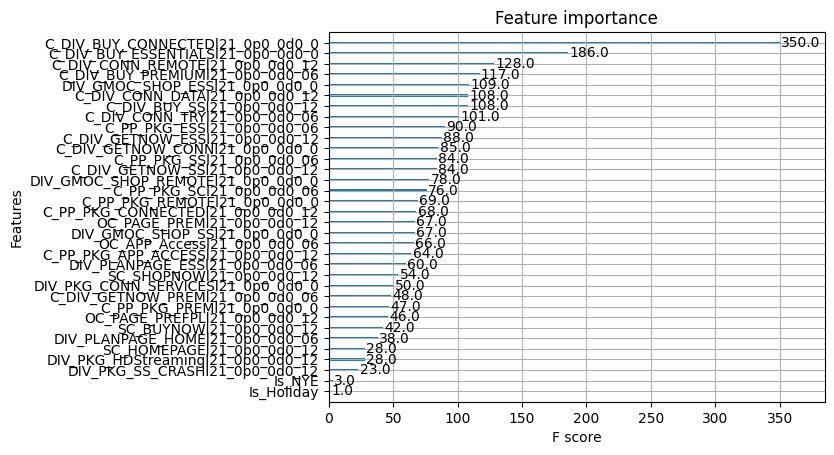

In [12]:
xgb.plot_importance(model_all)

### 2.1) Print the model evaluation metrics

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

Call the model evaluation metrics from the model and save to a dataframe "evaluation_metrics".

For linear regression models The ML.EVALUATE function returns: mean absolute error,mean squared erorr, mean squared log error, median absolute error, r-squared, and explained variance metrics.

In [ ]:
# %%bigquery evaluation_metrics
# SELECT *
# FROM ML.EVALUATE(MODEL `.RBA_demo.RBA_model`) #update project name

In [ ]:
# evaluation_metrics

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming 'model' is your trained model, and you have 'X_test' and 'y_test'
y_pred_test = model_train.predict(X_test)

# Calculate the metrics
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)


# Print the metrics
print(f"Model Fit Test")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print()



# Assuming 'model' is your trained model, and you have 'X_test' and 'y_test'
y_pred = model_all.predict(X_all)

# Calculate the metrics
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)


print(f"Model Fit All")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")



Model Fit Test
Mean Absolute Error (MAE): 120.53958684747869
Mean Squared Error (MSE): 18371.12216029604
Root Mean Squared Error (RMSE): 135.54011273529338
R-squared (R2): -1.2277935604674868

Model Fit All
Mean Absolute Error (MAE): 0.0013194534013856133
Mean Squared Error (MSE): 3.726915719936479e-06
Root Mean Squared Error (RMSE): 0.001930522136608767
R-squared (R2): 0.9999999999872422


WARNING: make sure evaluation metrics displayed in Colab match the BQ UI.

### 2.2) Visualize model fit

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

Select the predicted conversions (y1) of the model and actual conversions from the data (y1) using the ML.PREDICT function

In [ ]:
# %%bigquery model_predictions
# SELECT
#   *
# FROM
#   ML.PREDICT(MODEL `.RBA_demo.RBA_model`, #update project name
#     (
#     SELECT
#         *
#     FROM
#       `.RBA_demo.cleaned_data`
#       ORDER BY date)); #update project name

Visualize the model fit by comparing predicted vs. actual data.

In [14]:
results = pd.DataFrame()
results['actual'] = df[kpi_col]
results['predicted'] = y_pred

In [15]:
fig = px.line(results.sort_index())
fig.show()

## 3) Calculate contribution of each digital media tactic on conversions

To determine feature attribution, we use BQML's Global Explainability methodology. ML.GLOBAL_EXPLAIN provides explanations for the entire model by aggregating the local explanations of the evaluation data

In [ ]:
# %%bigquery feature_importance
# SELECT
#   *
# FROM
#   ML.GLOBAL_EXPLAIN(MODEL `RBA_demo.RBA_model`);

In [ ]:
#feature_importance

In [ ]:
# sum_feature_imp = feature_importance.attribution.sum()
# scale_factor = 0.99 # pulled from BQ UI

# feature_importance['attribution %'] = feature_importance.attribution / (sum_feature_imp / scale_factor)
# feature_importance.sort_values(by = 'attribution %', ascending = False)

In [ ]:
# feature_importance['attribution %'].sum()

In [16]:
# For xgboost
importances = model_all.feature_importances_

feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': importances})


In [17]:
sum_importance = feature_importance.importance.sum()
scale_factor = 0.99  # Adjust as needed

feature_importance['attribution %'] = feature_importance.importance / (sum_importance / scale_factor)
feature_importance.sort_values(by='attribution %', ascending=False, inplace=True)


In [18]:
total_scaled_importance = feature_importance['attribution %'].sum()
print(total_scaled_importance)


0.9900001


## 4) Export Final Results

In [19]:
final_results_df = feature_importance[['feature','attribution %']]
final_results_df.to_csv('rba_final_output_boosted.csv', encoding = 'utf-8-sig')
files.download('rba_final_output_boosted.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>